## CIFAR100
CIFAR100 torch dataset classification using EfficientNet-b0 Transfer Learning (?)

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from torchvision import transforms as tfs
from torchvision.datasets import CIFAR100

data_tfs = tfs.Compose([
    tfs.Resize(224),
    tfs.ToTensor(),
    tfs.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

# install for train and test
root = './'
train_val_dataset = CIFAR100(root, train=True,  transform=data_tfs, download=True)
test_dataset  = CIFAR100(root, train=False, transform=data_tfs, download=True)


Files already downloaded and verified
Files already downloaded and verified


Create train, valid, test dataloaders

In [ ]:
from torch.utils.data import Subset
train_idx, val_idx = train_test_split(list(range(len(train_val_dataset))), test_size=0.2)
train_dataset = Subset(train_val_dataset, train_idx)
valid_dataset = Subset(train_val_dataset, val_idx)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=100, shuffle=True)

Sizes of sets

In [ ]:
len(train_dataset),len(test_dataset), len(valid_dataset)

(40000, 10000, 10000)

## EfficientNet-b0

In [ ]:
!pip install -U efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b640ce77fa4d34ea0b3ef40e39080596a2946863d42d0415dadd91167a2a6cbd
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Freeze weights
for param in model.parameters():
    param.requires_grad = False
in_features = model._fc.in_features


# Defining Dense top layers after the convolutional layers


In [ ]:
model._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 100),
    )
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [ ]:
print(model)

Model Training

In [ ]:
# selecting loss function
criterion = nn.CrossEntropyLoss()

#using Adam classifier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
loaders={
      'train':train_dataloader,
      'valid':valid_dataloader
  }


In [ ]:
def train(model, optimizer, loaders, train_dataset_size, valid_dataset_size, save_path = "model.pt", n_epochs=5):

  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf 
  trainingloss = []
  validationloss = []
  accuracy = {"train":[], "valid":[]}

  for epoch in range(n_epochs):
      # initialize the variables to monitor training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      epoch_correct = 0
      epoch_all = 0
      print("Epoch:", epoch)
      
      for batch_idx, (data, target) in enumerate(loaders['train']):

          # move to GPU
          if use_cuda:
              data, target = data.cuda(), target.cuda()
        
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          
          train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

          preds = output.argmax(-1)
          correct = preds.eq(target.to(device)).sum()
          all = target.size(0)
          epoch_correct += correct.item()
          epoch_all += all

      print(f"Loader: train. Accuracy: {epoch_correct/epoch_all}")
      accuracy["train"].append(epoch_correct/epoch_all)


      epoch_correct = 0
      epoch_all = 0

      model.eval()
      for batch_idx, (data, target) in enumerate(loaders['valid']):
          if use_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
          preds = output.argmax(-1)
          correct = preds.eq(target.to(device)).sum()
          all = target.size(0)
          epoch_correct += correct.item()
          epoch_all += all
      
      
      print(f"Loader: valid. Accuracy: {epoch_correct/epoch_all}")
      accuracy["valid"].append(epoch_correct/epoch_all)

      train_loss = train_loss/train_dataset_size
      valid_loss = valid_loss/valid_dataset_size

      trainingloss.append(train_loss)
      validationloss.append(valid_loss)

      # printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, 
          train_loss,
          valid_loss
          ))
      
      ## saving the model if validation loss has decreased
      if valid_loss < valid_loss_min:
          torch.save(model.state_dict(), save_path)
          
          valid_loss_min = valid_loss
  return [model, accuracy,trainingloss, validationloss]
       

   

1-5 epochs

In [ ]:
history = train(model, optimizer, loaders, train_dataset_size, valid_dataset_size, "model.pt", 5)

Epoch: 0
Loader: train. Accuracy: 0.343625
Loader: valid. Accuracy: 0.5113
Epoch: 0 	Training Loss: 0.000077 	Validation Loss: 0.000215
Epoch: 1
Loader: train. Accuracy: 0.596575
Loader: valid. Accuracy: 0.617
Epoch: 1 	Training Loss: 0.000039 	Validation Loss: 0.000139
Epoch: 2
Loader: train. Accuracy: 0.674375
Loader: valid. Accuracy: 0.6356
Epoch: 2 	Training Loss: 0.000029 	Validation Loss: 0.000130
Epoch: 3
Loader: train. Accuracy: 0.723975
Loader: valid. Accuracy: 0.6454
Epoch: 3 	Training Loss: 0.000025 	Validation Loss: 0.000125
Epoch: 4
Loader: train. Accuracy: 0.764075
Loader: valid. Accuracy: 0.6539
Epoch: 4 	Training Loss: 0.000021 	Validation Loss: 0.000123


In [ ]:
model, accuracy, train_loss, valid_loss = history

6-10 epochs

In [ ]:
history2 = train(model, optimizer, loaders, train_dataset_size, valid_dataset_size, "model.pt", 5)

Epoch: 0
Loader: train. Accuracy: 0.80035
Loader: valid. Accuracy: 0.6551
Epoch: 0 	Training Loss: 0.000019 	Validation Loss: 0.000122
Epoch: 1
Loader: train. Accuracy: 0.831375
Loader: valid. Accuracy: 0.6552
Epoch: 1 	Training Loss: 0.000016 	Validation Loss: 0.000123
Epoch: 2
Loader: train. Accuracy: 0.8586
Loader: valid. Accuracy: 0.6547
Epoch: 2 	Training Loss: 0.000014 	Validation Loss: 0.000124
Epoch: 3
Loader: train. Accuracy: 0.884225
Loader: valid. Accuracy: 0.6572
Epoch: 3 	Training Loss: 0.000012 	Validation Loss: 0.000125
Epoch: 4
Loader: train. Accuracy: 0.907
Loader: valid. Accuracy: 0.6547
Epoch: 4 	Training Loss: 0.000010 	Validation Loss: 0.000127


Trying to increase the accurasy by decreasing learning rate 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

11-15 epochs

In [ ]:
history3 = train(model, optimizer, loaders, train_dataset_size, valid_dataset_size, "model.pt", 5)

Epoch: 0
Loader: train. Accuracy: 0.942975
Loader: valid. Accuracy: 0.6592
Epoch: 0 	Training Loss: 0.000008 	Validation Loss: 0.000126
Epoch: 1
Loader: train. Accuracy: 0.948525
Loader: valid. Accuracy: 0.6588
Epoch: 1 	Training Loss: 0.000008 	Validation Loss: 0.000127
Epoch: 2
Loader: train. Accuracy: 0.9525
Loader: valid. Accuracy: 0.6588
Epoch: 2 	Training Loss: 0.000007 	Validation Loss: 0.000127
Epoch: 3
Loader: train. Accuracy: 0.95695
Loader: valid. Accuracy: 0.6587
Epoch: 3 	Training Loss: 0.000007 	Validation Loss: 0.000128
Epoch: 4
Loader: train. Accuracy: 0.95995
Loader: valid. Accuracy: 0.6577
Epoch: 4 	Training Loss: 0.000007 	Validation Loss: 0.000129


## Loss and Accuracy Visualization

In [ ]:
model, accuracy2, train_loss2, valid_loss2 = history2
model, accuracy3, train_loss3, valid_loss3 = history3

valid_loss += valid_loss2
valid_loss += valid_loss3
train_loss += train_loss2
train_loss += train_loss3
for key in accuracy.keys():
  accuracy[key] += accuracy2[key]
  accuracy[key] += accuracy3[key]

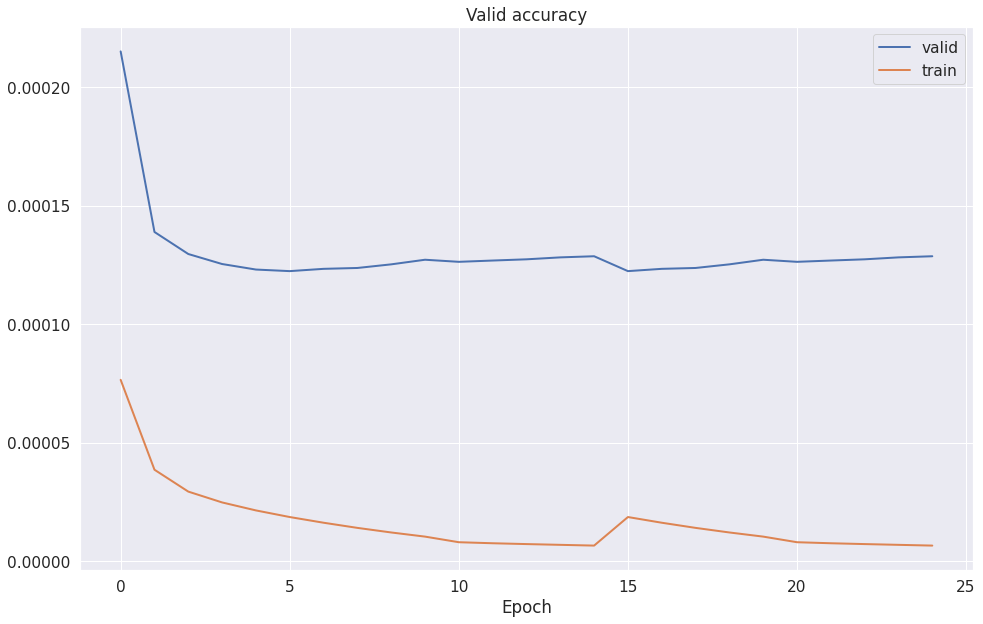

In [ ]:
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid loss")
plt.plot(valid_loss, label="valid", linewidth=2)
plt.plot(train_loss, label="train", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

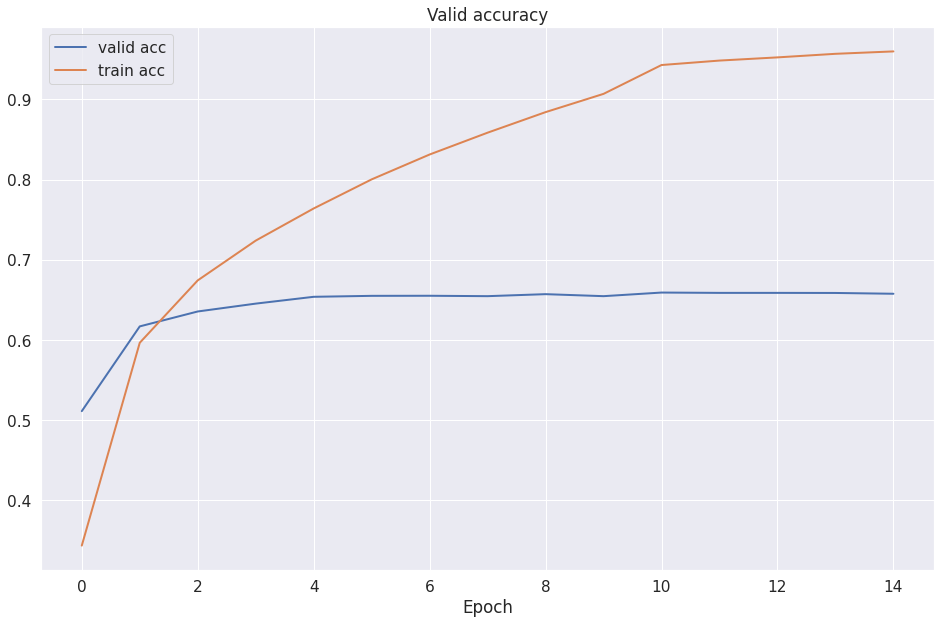

In [ ]:
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot( accuracy["valid"], label="valid acc", linewidth=2)
plt.plot( accuracy["train"], label="train acc", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

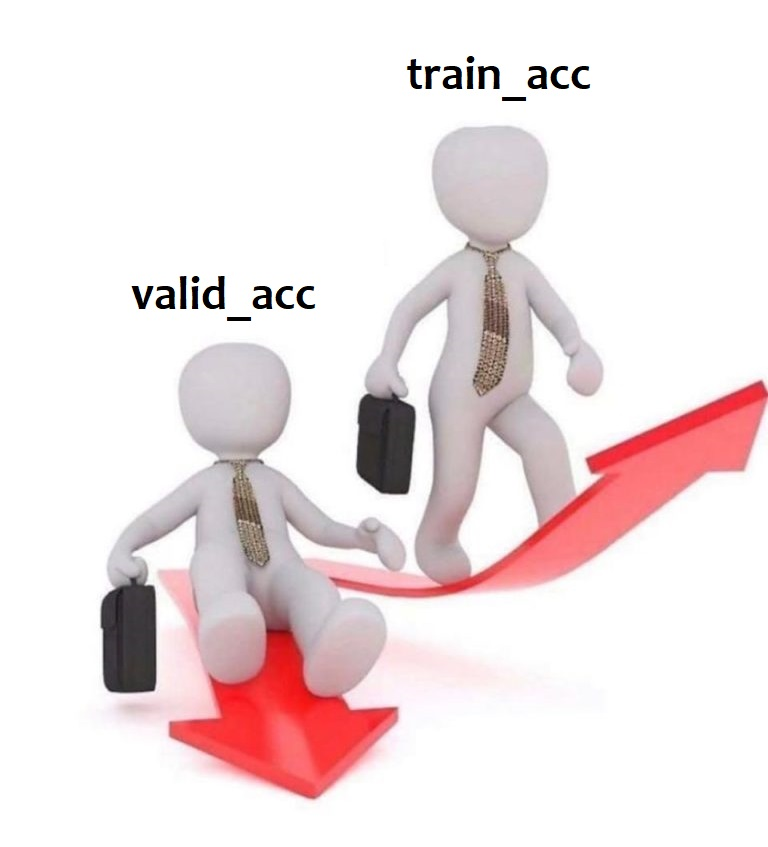

## Model Prediction

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        targets = []
        for inputs, target in test_loader:
            inputs = inputs.cuda()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            targets += target.data
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs, targets

In [ ]:
probs, targets = predict(model, test_dataloader)

preds = np.argmax(probs, axis=1)


In [ ]:
preds, targets[0].data

(array([99, 94, 37, ..., 81, 74, 14]), tensor(99))

Test Dataset Accuracy

In [ ]:
sum(preds==targets)/len(test_dataset)

0.6547

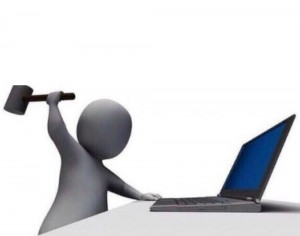